In [239]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split ,KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import classification_report






In [240]:
dataset  =  pd.read_csv('german_credit_data (1).csv')
dataset.head(5)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [241]:
dataset.drop('Unnamed: 0',axis=1,inplace=True)

In [242]:
dataset[['Saving accounts', 'Job', 'Housing','Checking account','Purpose']].apply(lambda x: (x.unique(), x.nunique()))

,Saving accounts,Job,Housing,Checking account,Purpose
0,"[nan, little, quite rich, rich, moderate]","[2, 1, 3, 0]","[own, free, rent]","[little, moderate, nan, rich]","[radio/TV, education, furniture/equipment, car..."
1,4,4,3,3,8


In [243]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [244]:
dataset.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

### We have a lot of values in savings and checking account column 

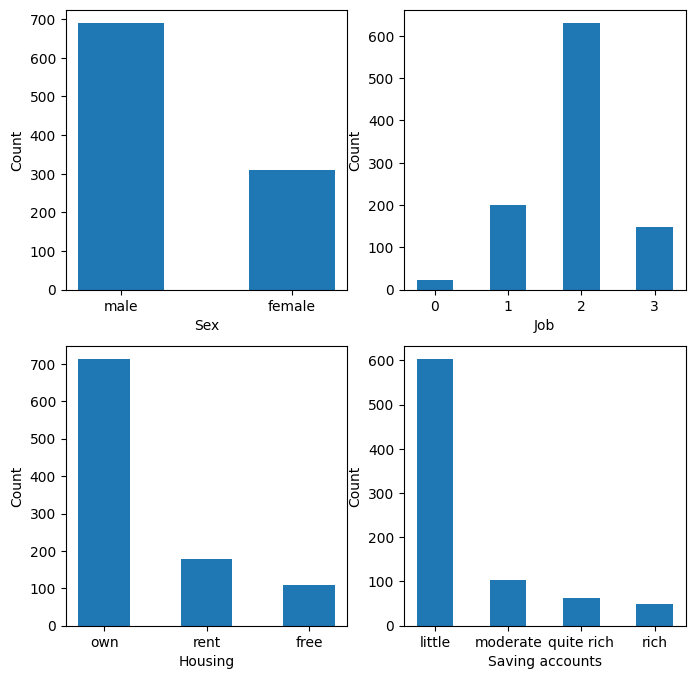

In [245]:
cat_column = ['Sex','Job','Housing','Saving accounts']
plt.figure(figsize=(8,8))
a = 1
for i in cat_column:
    plt.subplot(2,2,a)
    plt.bar(dataset[i].value_counts().index,dataset[i].value_counts().values,width=0.5)
    plt.xlabel(i)
    plt.ylabel('Count')
    a += 1


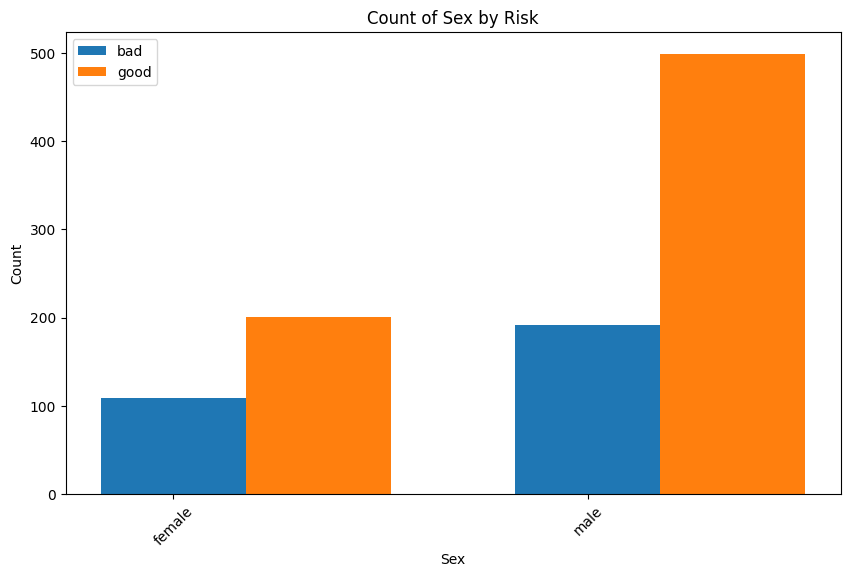

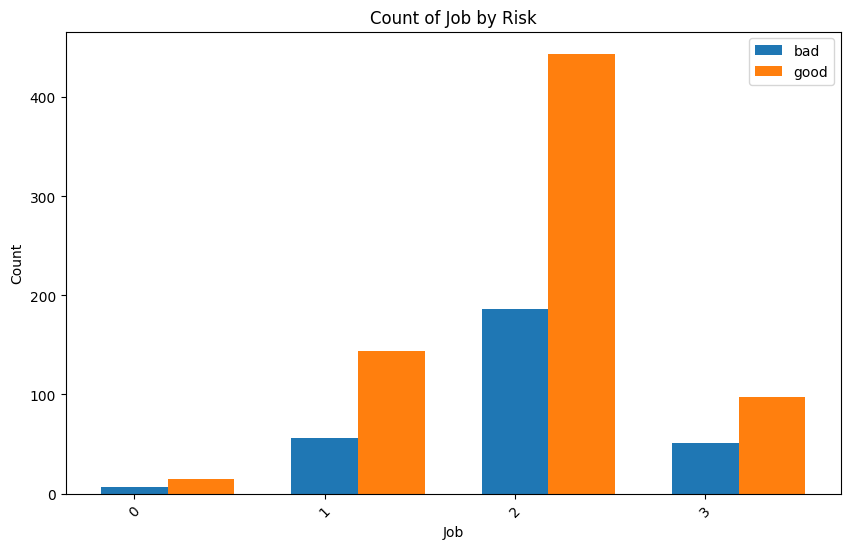

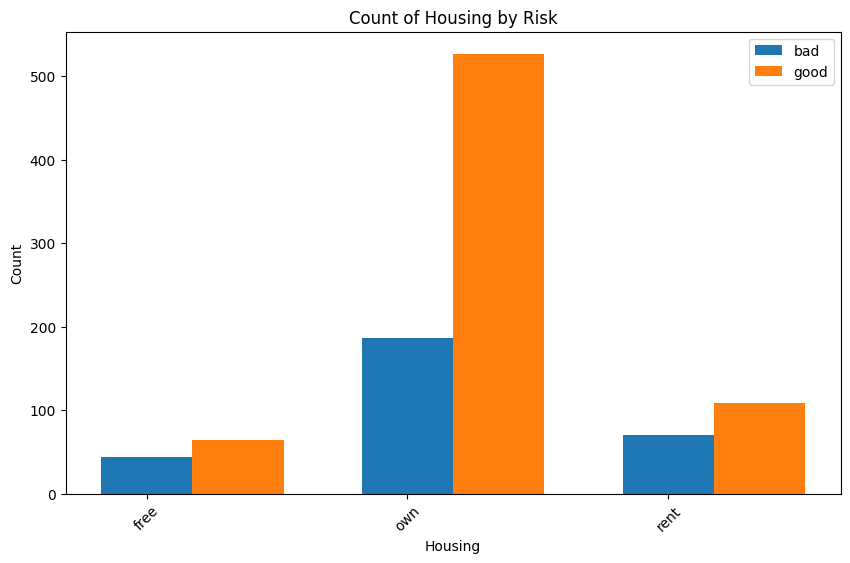

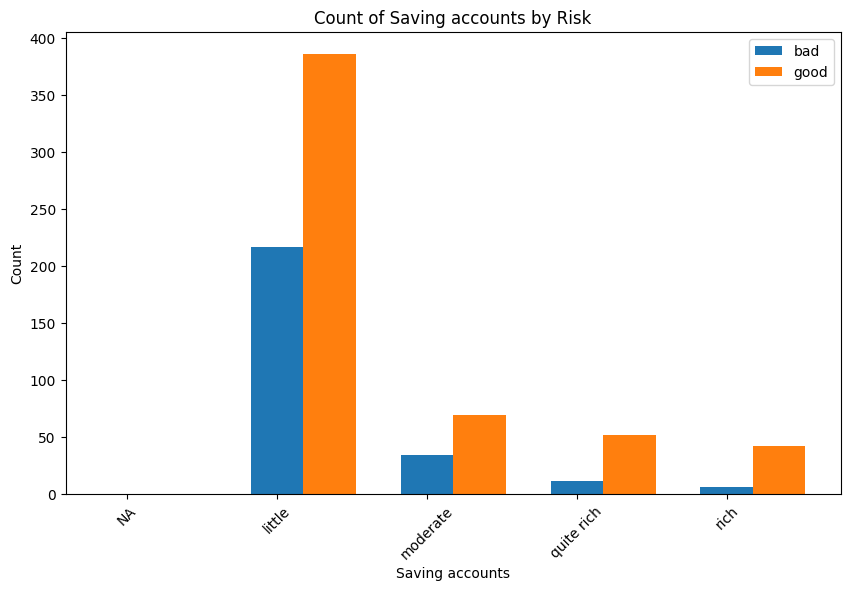

In [246]:
for i in cat_column:
    grouped_data = dataset.groupby([i, 'Risk']).size()
    

    col = sorted(dataset[i].fillna('NA').unique())
    risks = sorted(dataset['Risk'].unique())


    risk_counts = {job: [grouped_data.get((job, risk), 0) for risk in risks] for job in col}


    num_bars = len(risks)


    bar_width = 0.35


    x = range(len(col))


    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(num_bars):
        ax.bar([pos + j * bar_width for pos in x], [risk_counts[job][j] for job in col], bar_width, label=risks[j])

    ax.set_xlabel(i)
    ax.set_ylabel('Count')
    ax.set_title(f'Count of {i} by Risk')
    ax.set_xticks(x)
    ax.set_xticklabels(col, rotation=45)
    ax.legend()

plt.show()

#### Let's fill in the missing values first


In [247]:
le = LabelEncoder()
dataset['Risk']  = le.fit_transform(dataset['Risk'])

In [248]:
dataset.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


In [249]:
X_train,X_test,y_train,y_test = train_test_split(dataset.drop(columns=['Risk']).reset_index(drop=True),dataset['Risk'],test_size = 0.2,random_state = 10)

In [250]:
X_train.shape,y_train.shape

((800, 9), (800,))

In [251]:
X_train.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
188,20,male,2,own,moderate,little,674,12,radio/TV
194,21,male,2,rent,moderate,moderate,3031,45,radio/TV
225,27,male,2,own,little,NaN,2613,36,repairs
580,30,male,2,own,little,moderate,1056,18,car
428,20,male,2,own,little,NaN,1313,9,furniture/equipment


In [252]:
trf1 = ColumnTransformer([
    ('imputer',SimpleImputer(strategy='most_frequent'),[4,5]),
    ('scaler',MinMaxScaler(),[0,6,7])    
], remainder='passthrough')



trf2 = ColumnTransformer([
    ('transform3',OneHotEncoder(sparse_output=False,drop='first'),[5,7,8]),
    ('transform1',OrdinalEncoder(categories=[['little','moderate','rich']]),[1]),
    ('transform2',OrdinalEncoder(categories=[['little','moderate','quite rich','rich']]),[0]),
],remainder='passthrough')

In [253]:
X_train = trf1.fit_transform(X_train)
print(X_train[0])
X_train = trf2.fit_transform(X_train)

['moderate' 'little' 0.01785714285714285 0.0233300319137229
 0.1176470588235294 'male' 2 'own' 'radio/TV']


In [259]:
X_train[0]

array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,
       0.01785714285714285, 0.0233300319137229, 0.1176470588235294, 2],
      dtype=object)

In [254]:
X_test = trf1.fit_transform(X_test)
print(X_test[0])
X_test = trf2.fit_transform(X_test)

['little' 'little' 0.17391304347826092 0.18381334810301853
 0.3035714285714286 'male' 1 'own' 'car']


In [255]:
models = []
models.append(('LGR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGBM', XGBClassifier()))

results = []
names = []
scoring = 'accuracy'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=10, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f " % (name, cv_results.mean())

        print(msg)

        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)

        print(classification_report(y_test, y_test_pred))
    


LGR: 0.701250 
              precision    recall  f1-score   support

           0       0.75      0.19      0.31        62
           1       0.73      0.97      0.83       138

    accuracy                           0.73       200
   macro avg       0.74      0.58      0.57       200
weighted avg       0.73      0.73      0.67       200

KNN: 0.653750 
              precision    recall  f1-score   support

           0       0.45      0.24      0.32        62
           1       0.72      0.87      0.79       138

    accuracy                           0.68       200
   macro avg       0.59      0.56      0.55       200
weighted avg       0.64      0.68      0.64       200

NB: 0.656250 
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        62
           1       0.80      0.80      0.80       138

    accuracy                           0.73       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.73      0

### Using neural networks

In [319]:
import tensorflow as tf

# Define the input shape
input_shape = (16,)  


model = tf.keras.Sequential()


model.add(tf.keras.layers.Dense(1024, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [282]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [320]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 1024)              17408     
                                                                 
 dense_76 (Dense)            (None, 512)               524800    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_77 (Dense)            (None, 512)               262656    
                                                                 
 dense_78 (Dense)            (None, 256)               131328    
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)             

In [322]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.01,restore_best_weights=True)

In [323]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test), batch_size=32, callbacks=[early_stopping_callback])

Epoch 1/50
25/25 [==============================] - 3s 19ms/step - loss: 0.6227 - accuracy: 0.6812 - val_loss: 0.5992 - val_accuracy: 0.6900
Epoch 2/50
25/25 [==============================] - 0s 11ms/step - loss: 0.5942 - accuracy: 0.7025 - val_loss: 0.5602 - val_accuracy: 0.6900
Epoch 3/50
25/25 [==============================] - 1s 50ms/step - loss: 0.5856 - accuracy: 0.7025 - val_loss: 0.5552 - val_accuracy: 0.6900
Epoch 4/50
25/25 [==============================] - 1s 26ms/step - loss: 0.5807 - accuracy: 0.7025 - val_loss: 0.5730 - val_accuracy: 0.6900
Epoch 5/50
25/25 [==============================] - 0s 11ms/step - loss: 0.5820 - accuracy: 0.7025 - val_loss: 0.5827 - val_accuracy: 0.6900
Epoch 6/50
25/25 [==============================] - 0s 11ms/step - loss: 0.5785 - accuracy: 0.7025 - val_loss: 0.5573 - val_accuracy: 0.6900
Epoch 7/50
25/25 [==============================] - 0s 13ms/step - loss: 0.5603 - accuracy: 0.7013 - val_loss: 0.5526 - val_accuracy: 0.7100
Epoch 8/50
25